## Importance analysis and first perforance baselines

We will build a single decision tree to identify feature importances.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/data_clean.csv')
df.head(1)

,City,State,Bank,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,Default,NAICS_i,isNewBusiness,isFranchise,SBARatio,InterestRate
0,EVANSVILLE,IN,FIFTH THIRD BANK,1997,84,4,0,0,1,0,0,1,60000.0,48000.0,0,45,1.0,0,0.8,5.19


In [3]:
target = 'Default'

In [4]:
# Add UrbanRural one-hot encoded version diretly to the dataframe. That encoding is straighforward.
df = pd.get_dummies(data=df, columns=['UrbanRural'], prefix='UrbanRural')

all_features = [feature for feature in df.columns if feature not in target]

In [5]:
df.head(1)

,City,State,Bank,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,RevLineCr,...,SBA_Appv,Default,NAICS_i,isNewBusiness,isFranchise,SBARatio,InterestRate,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,EVANSVILLE,IN,FIFTH THIRD BANK,1997,84,4,0,0,1,0,...,48000.0,0,45,1.0,0,0.8,5.19,True,False,False


## Baseline performances

In [6]:
print(f'Our ratio of target variable is {df[target].mean()} ')
print(f"The baseline accuracy of a trivial model is {(1-df[target].mean())*100:.2f}%!")

Our ratio of target variable is 0.1714619179013778 
The baseline performance of a trivial model is 82.85%!


This means that a model that always predicted that a loan will not default will result in a performance of almost 83%! If our model performs close to that number it would be considered useless.

In [7]:
# This trivial model always identifies a loan as paid in full. Let's score it.
def trivial_model(X: pd.DataFrame):
    return np.zeros((len(X), 1))

from sklearn.metrics import accuracy_score, f1_score
trivial_acc = accuracy_score(df[target], trivial_model(df))
trivial_f1 = f1_score(df[target], trivial_model(df))

print(f"Our trivial model has {trivial_acc*100:.2f}% accuracy!")
print(f"However, it has {trivial_f1*100:.2f}% F1 score. (0 recall and 0 precision)")


Our trivial model has 82.85% accuracy!
However, it has 0.00% F1 score. (0 recall and 0 precision)


Therefore, accuracy won't be used as a metric. We will prefer others like recall, precision, F1 or ROC AUC.

## Part I: Feature importance
Importance ranking and RFE

In [8]:
experimental_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
features = [f for f in all_features if f not in experimental_features]
print(f"We will use RFE to choose some of {features}")
print(f"Then find if we should include {experimental_features} and how.")

We will use RFE to choose some of ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isNewBusiness', 'isFranchise', 'SBARatio', 'InterestRate', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']
Then find if we should include ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode'] and how.


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_, y_train, y_ = train_test_split(df[features], df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"X -- Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")


X -- Train shape: (652885, 15), CV: (108814, 15), test: (108815, 15)
y -- Train shape: (652885,), CV: (108814,), test: (108815,)


In [10]:
# Choose hyperparameters to be tried. We will tune by hand the minimum number of samples in a leaf to do another split and the maximum depth
# to which the tree can reach.

min_samples_list = [20, 50, 100, 200, 500, 1000, 10000]
max_depths_list = [4, 8, 12, 16, 20, 32, 64, None]

Optimum minimum samples to split is 200. CV F1: 0.8200178441073891


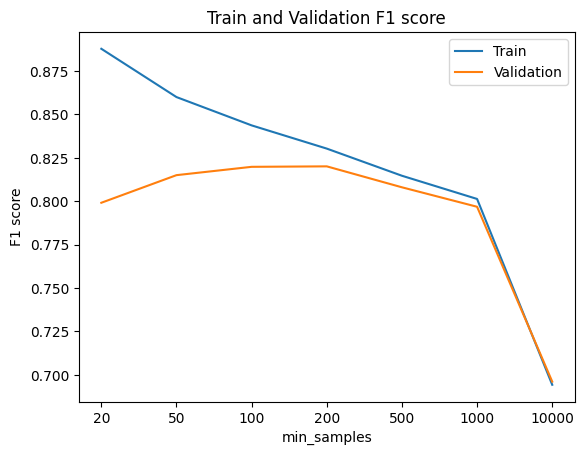

In [11]:
# F1 score will be used as a metric, as the cost of false negatives (defaulted loans which we fail to detect) is
# higher than that of false positives (paid in full loans we flag as default). 

from sklearn.tree import DecisionTreeClassifier # Single tree
from sklearn.metrics import f1_score

# Recall array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for min_sample in min_samples_list:

    # Train a model for each one.
    model = DecisionTreeClassifier(min_samples_split=min_sample).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_min_samples = min_samples_list[np.argmax(f1s['cv'])]
print(f"Optimum minimum samples to split is {optimum_min_samples}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('min_samples')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(min_samples_list )),labels=min_samples_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum maximum depth to stop is 16. CV F1: 0.8145124226121279


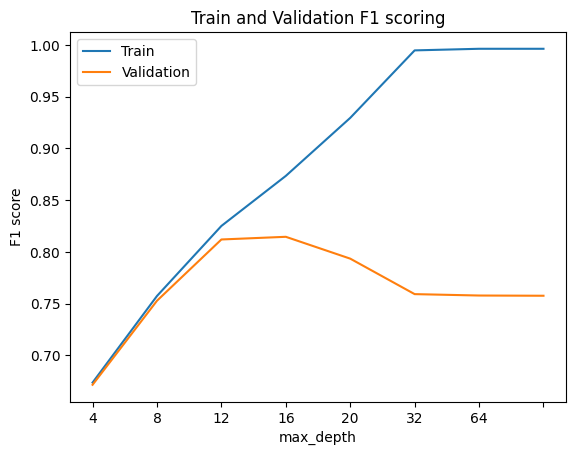

In [12]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the max depths list.
for max_depth in max_depths_list:
    
    model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimimum_max_depth = max_depths_list[np.argmax(f1s['cv'])]

print(f"Optimum maximum depth to stop is {optimimum_max_depth}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 scoring')
plt.xlabel('max_depth')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(max_depths_list)),labels=max_depths_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])


In [13]:
# Now let's pick both of these together and train a model!
tree = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train, y_train)

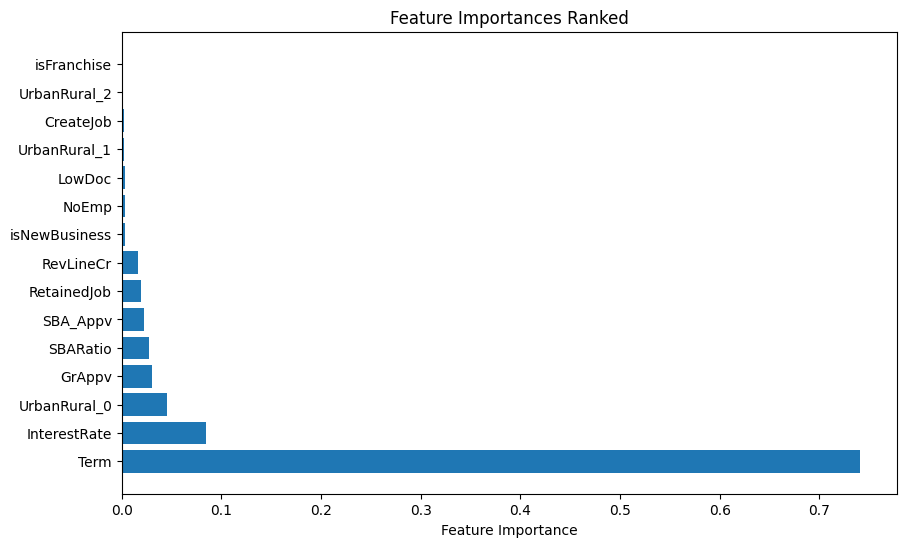

In [14]:
# Get feature importances from the trained model
importances = tree.feature_importances_

top_indices = np.argsort(importances)[::-1]

top_importances = importances[top_indices]
top_feature_names = np.array(features)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances Ranked')
plt.show()

Now we'll try to drop a few of these to see if it isn't a significative loss of score. First, let's get our model's score to have a comparison:

In [15]:
# Lil' scoring function
from sklearn.metrics import recall_score, f1_score
def little_scorer (y_true, y_pred, name: str) -> pd.DataFrame:
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return pd.DataFrame({
        'Recall': recall,
        'F1': f1
    }, index=[name])

In [16]:
yhat_test = tree.predict(X_test)

In [17]:
scores = little_scorer(y_test, yhat_test, "Baseline Test")
scores

,Recall,F1
Baseline Test,0.803255,0.817888


                  Recall        F1
Baseline Test   0.803255  0.817888
Baseline Total  0.809969  0.825945


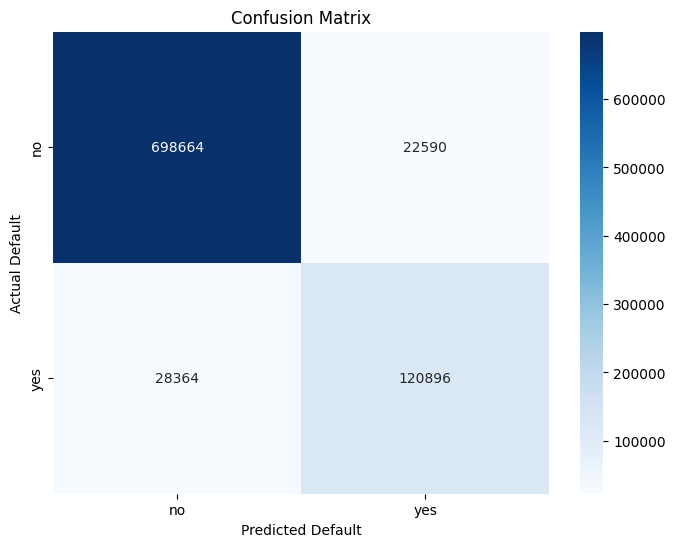

In [18]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
yhat_total = tree.predict(df[features])
cm = confusion_matrix(df[target], yhat_total)

scores = pd.concat([scores, little_scorer(df[target], yhat_total, "Baseline Total")])
print(scores)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Let's pick the 8 best features
features_rfe = top_feature_names[:8]

In [20]:
# Same tree with only 8 features
tree = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train[features_rfe], y_train)

In [21]:
yhat_test = tree.predict(X_test[features_rfe])

scores = pd.concat([scores, little_scorer(y_test, yhat_test, 'RFE Test')])
scores

,Recall,F1
Baseline Test,0.803255,0.817888
Baseline Total,0.809969,0.825945
RFE Test,0.802177,0.817867


                  Recall        F1
Baseline Test   0.803255  0.817888
Baseline Total  0.809969  0.825945
RFE Test        0.802177  0.817867
RFE Total       0.808180  0.825564


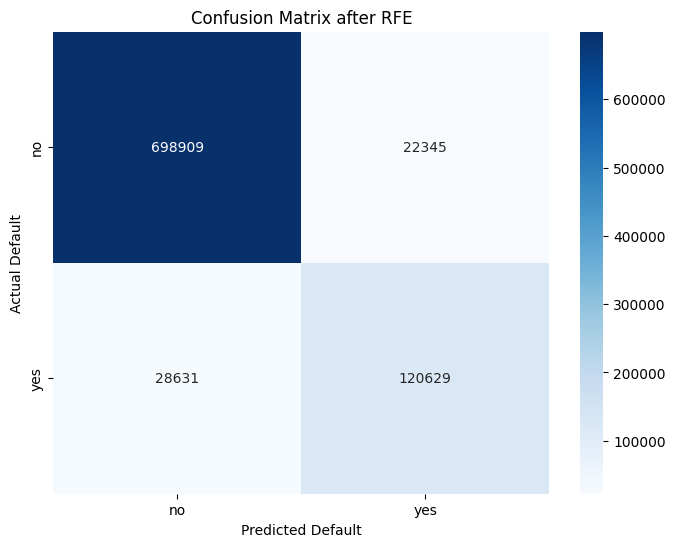

In [22]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
yhat_total = tree.predict(df[features_rfe])
cm = confusion_matrix(df[target], yhat_total)

scores = pd.concat([scores, little_scorer(df[target], yhat_total, "RFE Total")])
print(scores)
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix after RFE')
plt.show()

The loss is minimum, so we can safely go with only 8 features, shortening the training times.

## Part II: Encoding techniques
### Count encoding

In [23]:
# Count encoding
count_encoded_features = ['City', 'Bank', 'State']
features_count_encoding = list(features_rfe) + count_encoded_features

In [24]:
for feature in count_encoded_features:
    df[feature + 'Loans'] = df.groupby(feature)[feature].transform('count')
    df[feature + 'Loans'].fillna(0, inplace=True)

    features_count_encoding.remove(feature)
    features_count_encoding.append(feature+'Loans')

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_, y_train, y_ = train_test_split(df[features_count_encoding], df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"X -- Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")


X -- Train shape: (652885, 11), CV: (108814, 11), test: (108815, 11)
y -- Train shape: (652885,), CV: (108814,), test: (108815,)


In [26]:
from itertools import combinations

# Generate combinations of different lengths (0 to 3) of the count encoded features
all_combinations = []
for r in range(4):
    combinations_r = list(combinations(['CityLoans', 'BankLoans', 'StateLoans'], r))
    all_combinations.extend(combinations_r)

In [27]:
best_features = []
best_f1 = 0
for combination in all_combinations:
    print(f"\nParameters Added: {combination}")

    #extended_features = [item for item in features_count_encoding if item not in list(combination)]
    extended_features = list(features_rfe) + (list(combination))

    tree = DecisionTreeClassifier(
        min_samples_split=optimum_min_samples,
        max_depth=optimimum_max_depth).fit(X_train[extended_features], y_train)
    
    yhat_train = tree.predict(X_train[extended_features])
    yhat_cv = tree.predict(X_cv[extended_features])

    train_recall = recall_score(y_train, yhat_train)
    train_f1 = f1_score(y_train, yhat_train)

    cv_recall = recall_score(y_cv, yhat_cv)
    cv_f1 = f1_score(y_cv, yhat_cv)
    
    if cv_f1 > best_f1:
        best_features = extended_features
        best_f1 = cv_f1

    print(f"Our model has a train recall of {train_recall*100:.2f}%, F1 of {train_f1*100:.2f}%!")
    print(f"CV recall of {cv_recall*100:.2f}%, F1 of {cv_f1*100:.2f}%!")
    print(f"Best so far: {best_f1} with features {best_features}")
    


Parameters Added: ()
Our model has a train recall of 81.21%, F1 of 82.90%!
CV recall of 80.20%, F1 of 82.00%!
Best so far: 0.8199814075572812 with features ['Term', 'InterestRate', 'UrbanRural_0', 'GrAppv', 'SBARatio', 'SBA_Appv', 'RetainedJob', 'RevLineCr']

Parameters Added: ('CityLoans',)
Our model has a train recall of 81.15%, F1 of 82.92%!
CV recall of 80.16%, F1 of 81.98%!
Best so far: 0.8199814075572812 with features ['Term', 'InterestRate', 'UrbanRural_0', 'GrAppv', 'SBARatio', 'SBA_Appv', 'RetainedJob', 'RevLineCr']

Parameters Added: ('BankLoans',)
Our model has a train recall of 82.60%, F1 of 83.98%!
CV recall of 81.34%, F1 of 82.87%!
Best so far: 0.8287193460490464 with features ['Term', 'InterestRate', 'UrbanRural_0', 'GrAppv', 'SBARatio', 'SBA_Appv', 'RetainedJob', 'RevLineCr', 'BankLoans']

Parameters Added: ('StateLoans',)
Our model has a train recall of 81.45%, F1 of 83.02%!
CV recall of 80.45%, F1 of 82.15%!
Best so far: 0.8287193460490464 with features ['Term', 'Int

In [28]:
features_count_encoding = best_features

In [29]:
# Let's score the model
tree = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train[features_count_encoding], y_train)

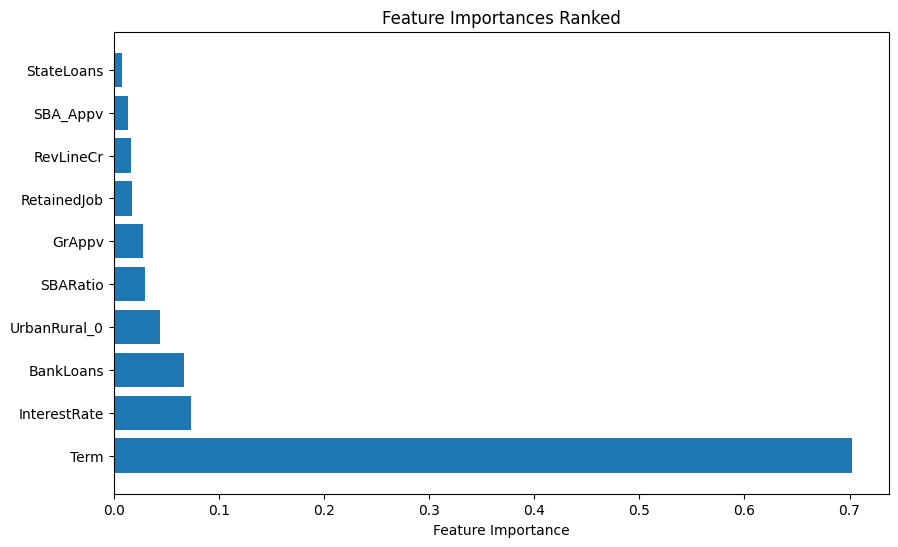

In [30]:
# Get feature importances from the trained model
importances = tree.feature_importances_

top_indices = np.argsort(importances)[::-1]

top_importances = importances[top_indices]
top_feature_names = np.array(features_count_encoding)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances Ranked')
plt.show()

In [31]:
yhat_test = tree.predict(X_test[features_count_encoding])

scores = pd.concat([scores, little_scorer(y_test, yhat_test, "Count Encoding Test")])
scores

,Recall,F1
Baseline Test,0.803255,0.817888
Baseline Total,0.809969,0.825945
RFE Test,0.802177,0.817867
RFE Total,0.808180,0.825564
Count Encoding Test,0.816846,0.830938


                        Recall        F1
Baseline Test         0.803255  0.817888
Baseline Total        0.809969  0.825945
RFE Test              0.802177  0.817867
RFE Total             0.808180  0.825564
Count Encoding Test   0.816846  0.830938
Count Encoding Total  0.822323  0.837387


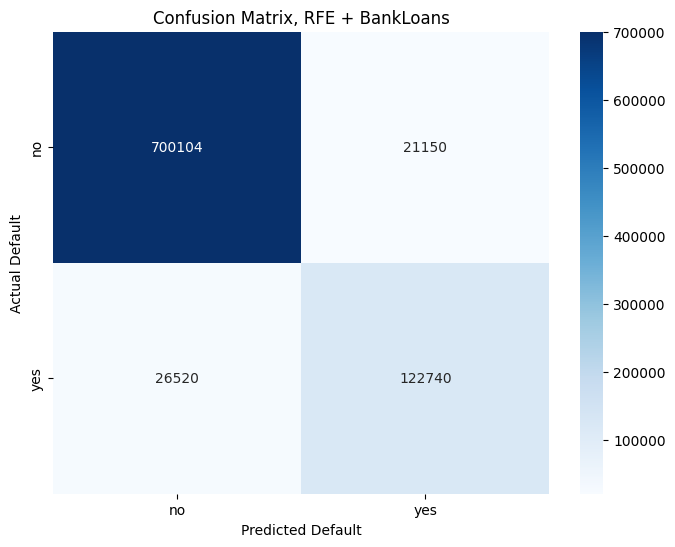

In [32]:
# Calculate the confusion matrix
yhat_total = tree.predict(df[features_count_encoding])
cm = confusion_matrix(df[target], yhat_total)

scores = pd.concat([scores, little_scorer(df[target], yhat_total, "Count Encoding Total")])
print(scores)
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix, RFE + Count Encoding')
plt.show()

### Target encoding

In [33]:
# Now, let's play with target encodings.
target_encoders = ['City', 'State', 'Bank', 'FranchiseCode', 'NAICS_i']
features_target_encoding = features_count_encoding + target_encoders


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_, y_train, y_ = train_test_split(df[features_target_encoding], df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"X -- Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")


X -- Train shape: (652885, 15), CV: (108814, 15), test: (108815, 15)
y -- Train shape: (652885,), CV: (108814,), test: (108815,)


In [35]:
target_encoded_names = ['CityDefault', 'StateDefault', 'BankDefault', 'FranchiseDefault', 'NAICSDefault']
all_combinations = []
for r in range(len(target_encoded_names) + 1):
    combinations_r = list(combinations(target_encoded_names, r))
    all_combinations.extend(combinations_r)

In [36]:
from sklearn.preprocessing import TargetEncoder

target_encoder = TargetEncoder()
# Use the training data to fit the encoder
X_train_encoded_fields = target_encoder.fit_transform(X_train[target_encoders], y_train)
X_train_encoded_fields = pd.DataFrame(X_train_encoded_fields,columns=target_encoded_names)
X_train_encoded_fields = X_train_encoded_fields.set_index(X_train.index)

X_train_encoded = pd.concat([X_train, X_train_encoded_fields], axis=1)

In [37]:
# Encode the CV set
X_cv_encoded_fields = target_encoder.transform(X_cv[target_encoders])
X_cv_encoded_fields = pd.DataFrame(X_cv_encoded_fields,columns=target_encoded_names)
X_cv_encoded_fields = X_cv_encoded_fields.set_index(X_cv.index)

X_cv_encoded = pd.concat([X_cv, X_cv_encoded_fields], axis=1)

In [38]:
# Encode the test set
X_test_encoded_fields = target_encoder.transform(X_test[target_encoders])
X_test_encoded_fields = pd.DataFrame(X_test_encoded_fields,columns=target_encoded_names)
X_test_encoded_fields = X_test_encoded_fields.set_index(X_test.index)

X_test_encoded = pd.concat([X_test, X_test_encoded_fields], axis=1)

In [39]:
best_f1 = 0
best_features = []

for combination in all_combinations:
    print(f"\nParameters Target Encoded: {combination}")
    
    #extended_features = [item for item in features_count_encoding if item not in list(combination)]
    extended_features = list(features_count_encoding) + (list(combination))

    tree = DecisionTreeClassifier(
        min_samples_split=optimum_min_samples,
        max_depth=optimimum_max_depth).fit(X_train_encoded[extended_features], y_train)
    
    yhat_train = tree.predict(X_train_encoded[extended_features])
    yhat_cv = tree.predict(X_cv_encoded[extended_features])

    train_recall = recall_score(y_train, yhat_train)
    train_f1 = f1_score(y_train, yhat_train)

    cv_recall = recall_score(y_cv, yhat_cv)
    cv_f1 = f1_score(y_cv, yhat_cv)

    if cv_f1 > best_f1:
        best_features = extended_features
        best_f1 = cv_f1
    
    print(f"Our model has a train recall of {train_recall*100:.2f}%, F1 of {train_f1*100:.2f}%!")
    print(f"CV recall of {cv_recall*100:.2f}%, F1 of {cv_f1*100:.2f}%!")
    print(f"Best so far: {best_f1} with features {best_features}")
    


Parameters Target Encoded: ()
Our model has a train recall of 82.33%, F1 of 83.98%!
CV recall of 81.99%, F1 of 83.50%!
Best so far: 0.8349968723653077 with features ['Term', 'InterestRate', 'UrbanRural_0', 'GrAppv', 'SBARatio', 'SBA_Appv', 'RetainedJob', 'RevLineCr', 'BankLoans', 'StateLoans']

Parameters Target Encoded: ('CityDefault',)
Our model has a train recall of 82.42%, F1 of 83.95%!
CV recall of 81.92%, F1 of 83.26%!
Best so far: 0.8349968723653077 with features ['Term', 'InterestRate', 'UrbanRural_0', 'GrAppv', 'SBARatio', 'SBA_Appv', 'RetainedJob', 'RevLineCr', 'BankLoans', 'StateLoans']

Parameters Target Encoded: ('StateDefault',)
Our model has a train recall of 81.81%, F1 of 83.81%!
CV recall of 81.32%, F1 of 83.15%!
Best so far: 0.8349968723653077 with features ['Term', 'InterestRate', 'UrbanRural_0', 'GrAppv', 'SBARatio', 'SBA_Appv', 'RetainedJob', 'RevLineCr', 'BankLoans', 'StateLoans']

Parameters Target Encoded: ('BankDefault',)
Our model has a train recall of 82.19%

It seems like adding Bank and Franchise default risks makes a better model!!

In [40]:
features_target_encoding = best_features

In [41]:
# Let's score the model
tree = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train_encoded[features_target_encoding], y_train)

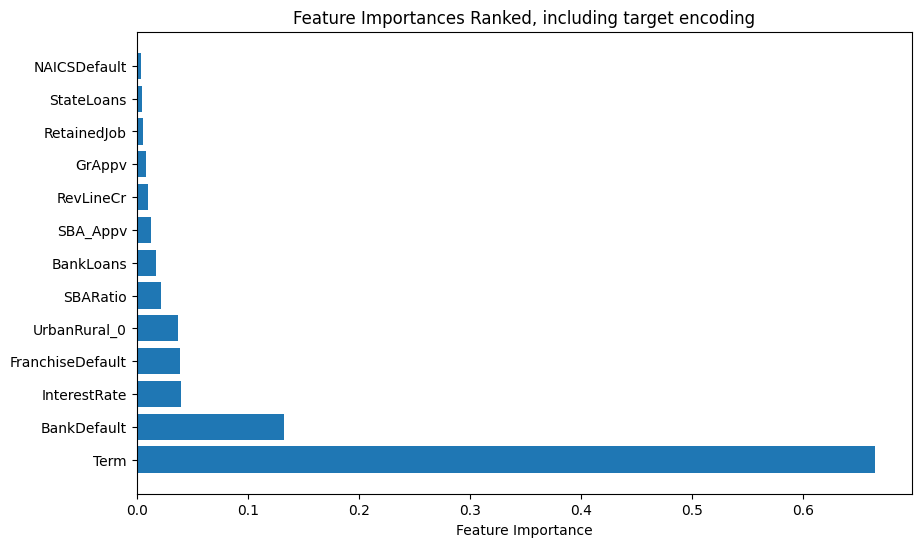

In [42]:
# Get feature importances from the trained model
importances = tree.feature_importances_

top_indices = np.argsort(importances)[::-1]

top_importances = importances[top_indices]
top_feature_names = np.array(features_target_encoding)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances Ranked, including target encoding')
plt.show()

In [43]:
yhat_test = tree.predict(X_test_encoded[features_target_encoding])
scores = pd.concat([scores, little_scorer(y_test, yhat_test, "Target Encoding Test")])
scores

,Recall,F1
Baseline Test,0.803255,0.817888
Baseline Total,0.809969,0.825945
RFE Test,0.802177,0.817867
RFE Total,0.808180,0.825564
Count Encoding Test,0.816846,0.830938
Count Encoding Total,0.822323,0.837387
Target Encoding Test,0.816876,0.831953


                         Recall        F1
Baseline Test          0.803255  0.817888
Baseline Total         0.809969  0.825945
RFE Test               0.802177  0.817867
RFE Total              0.808180  0.825564
Count Encoding Test    0.816846  0.830938
Count Encoding Total   0.822323  0.837387
Target Encoding Test   0.816876  0.831953
Target Encoding Total  0.826631  0.842305


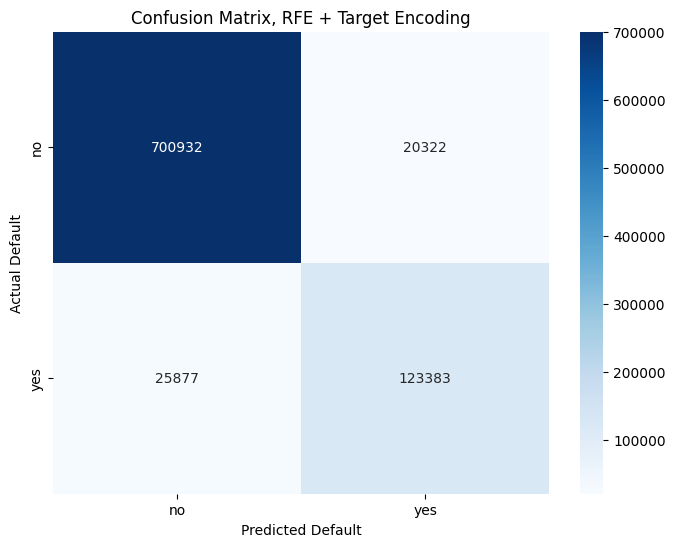

In [44]:
# Calculate the confusion matrix

df_encoded_fields = target_encoder.transform(df[target_encoders])
df_encoded_fields = pd.DataFrame(df_encoded_fields, columns=target_encoded_names)
df_encoded_fields.set_index(df.index)

df_encoded = pd.concat([df, df_encoded_fields], axis=1)

yhat_total = tree.predict(df_encoded[features_target_encoding])
cm = confusion_matrix(df[target], yhat_total)

scores = pd.concat([scores, little_scorer(df[target], yhat_total, "Target Encoding Total")])
print(scores)
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix, RFE + Target Encoding')
plt.show()

### One-hot encoding
Now we will see if one-hot encoding NAICS_i provides any improvement

In [45]:
features_one_hot = features_count_encoding + ['NAICS_i']

In [46]:
df_one_hot = pd.get_dummies(
    data = df[features_one_hot],
    columns=['NAICS_i'],
    prefix=['NAICS_i']
)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_, y_train, y_ = train_test_split(df_one_hot, df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"X -- Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")


X -- Train shape: (652885, 35), CV: (108814, 35), test: (108815, 35)
y -- Train shape: (652885,), CV: (108814,), test: (108815,)


In [48]:
# Let's score the model
tree = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train, y_train)

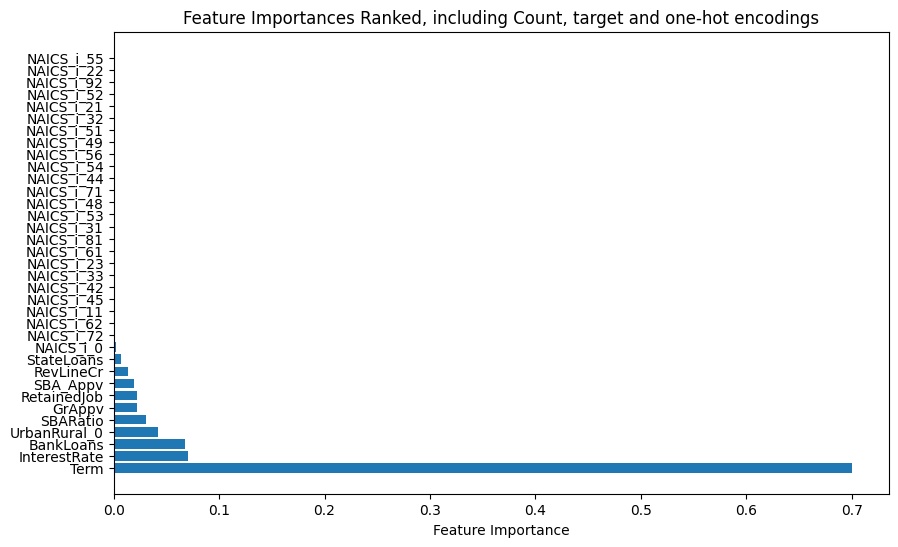

In [49]:
# Get feature importances from the trained model
importances = tree.feature_importances_

top_indices = np.argsort(importances)[::-1]

top_importances = importances[top_indices]
top_feature_names = np.array(X_train.columns)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances Ranked, including Count, target and one-hot encodings')
plt.show()

In [50]:
yhat_test = tree.predict(X_test)
scores = pd.concat([scores, little_scorer(y_test, yhat_test, 'One-Hot encoding Test')])
scores

,Recall,F1
Baseline Test,0.803255,0.817888
Baseline Total,0.809969,0.825945
RFE Test,0.802177,0.817867
RFE Total,0.808180,0.825564
Count Encoding Test,0.816846,0.830938
Count Encoding Total,0.822323,0.837387
Target Encoding Test,0.816876,0.831953
Target Encoding Total,0.826631,0.842305
One-Hot encoding Test,0.807368,0.828407


                          Recall        F1
Baseline Test           0.803255  0.817888
Baseline Total          0.809969  0.825945
RFE Test                0.802177  0.817867
RFE Total               0.808180  0.825564
Count Encoding Test     0.816846  0.830938
Count Encoding Total    0.822323  0.837387
Target Encoding Test    0.816876  0.831953
Target Encoding Total   0.826631  0.842305
One-Hot encoding Test   0.807368  0.828407
One-hot encoding Total  0.817821  0.836400


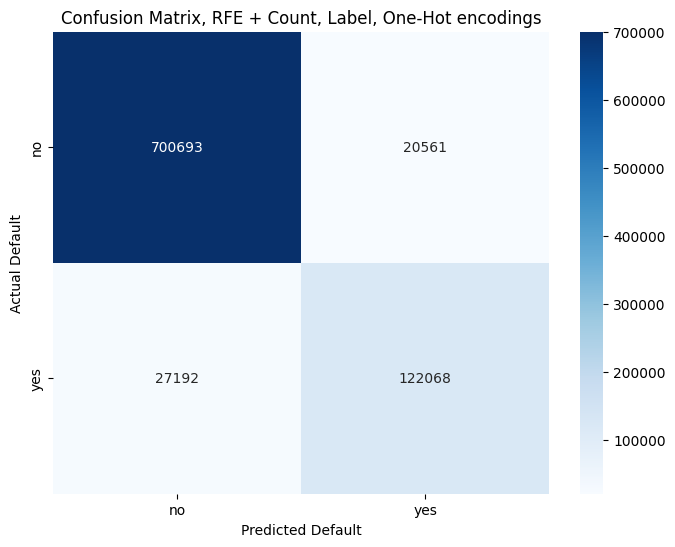

In [51]:
# Calculate the confusion matrix

yhat_total = tree.predict(df_one_hot)
cm = confusion_matrix(df[target], yhat_total)

scores = pd.concat([scores, little_scorer(df[target], yhat_total, "One-hot encoding Total")])
print(scores)
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix, RFE + Count, Label, One-Hot encodings')
plt.show()